In [1]:
# %pip install --quiet --upgrade pip 
# %pip install numpy --quiet
# %pip install Pandas --quiet
# %pip install sklearn --quiet
# %pip install ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Horse Racing Results Predictor #

The American professional gambler [Bill Benter](https://en.wikipedia.org/wiki/Bill_Benter) is said to have made earned nearly $1 billion through the development of one of the most successful analysis computer software programs in the horse racing market.

Bill published his techniques in the paper [Computer-Based Horse Race Handicapping and Wagering Systems](https://www.gwern.net/docs/statistics/decision/1994-benter.pdf). 

The [YouTube Video by Ken Jee](https://www.youtube.com/watch?v=KEeUR8UDy-s) outlines how he did it, how difficult it was, and discusses whether it is likely to be able to replicate this feat today (hint: Ken thinks it highly unlikely for a number of reasons).

Inspired by video, this notebook examines the possibility of replicating Bill's success using data from modern day UK races.

**NOTE: This is a fun examination of the technique the can be used in predicting races. It is not intended to be accurate or valid. The author accepts no responsibility for the correctness, completeness or quality of the information provided. Please do not use this information to place any real-world bets. Gambling odds are always skewed in favour of the bookmaker and you will lose in the long run.**

In [2]:
import numpy as np
import pandas as pd
import math
from abc import ABC, abstractmethod
from datetime import datetime, date

### Step 1: Load in the historic race data and ignore any horse that didn't complete the race

In [3]:
import glob
from datetime import timedelta
results_files = glob.glob('Results_*.csv')
results_files

history = pd.concat([pd.read_csv(f) for f in results_files])
history = history[history['ResultStatus'] == 'CompletedRace']
history['Off'] =  pd.to_datetime(history['Off'], format='%m/%d/%Y %H:%M:%S')
history['Wins'] = history.apply(lambda r: 1 if r['FinishingPosition'] == 1 else 0, axis=1)

### Analyse factors to understand if they have influence on the outcome of races. 

Bill Benter suggested the following attributes:

Current condition:
- performance in recent races
- time since last race
- recent workout data
- age of horse

Past performance:
- finishing position in past races
- lengths behind winner in past races
- normalized times of past races

Adjustments to past performance:
- strength of competition in past races
- weight carried in past races
- jockey's contribution to past performances
- compensation for bad luck in past races
- compensation for advantageous or disadvantageous post position in past races

Present race situational factors:
- weight to be carried
- today's jockey's ability
- advantages or disadvantages of the assigned post position

Preferences which could influence the horse's performance in today's race:
- distance preference
- surface preference (turf vs dirt)
- condition of surface preference (wet vs dry)
- specific track preference

In [4]:
history.columns

Index(['RaceId', 'RaceName', 'CourseId', 'CourseName', 'Off', 'RaceType',
       'Class', 'Pattern', 'RatingBand', 'AgeBand', 'SexRestriction',
       'Distance', 'DistanceInFurlongs', 'DistanceInMeters', 'DistanceInYards',
       'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'TrainerId', 'TrainerName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'Weight', 'WeightInPounds', 'FractionalOdds',
       'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'ResultStatus', 'FinishingPosition', 'BeatenDistance',
       'OverallBeatenDistance', 'RaceTime', 'RaceTimeInSeconds', 'Wins'],
      dtype='object')

In [5]:
races = history[['RaceId', 'CourseId', 'RaceType', 'Off', 'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'DistanceInMeters', 'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'Age', 'HeadGear', 'RaceCardNumber','StallNumber', 'WeightInPounds', 
       'FinishingPosition','OverallBeatenDistance', 'RaceTimeInSeconds', 'Wins']].copy()

### Expand categorical variables

In [6]:
surface_categories = ["Surface_AllWeather", "Surface_Dirt", "Surface_Turf"]
races = races.drop(surface_categories + ["Surface_Unknown"], axis=1, errors='ignore')
races["SurfaceTemp"] = races["Surface"]
races = pd.get_dummies(races, prefix="Surface", columns=["SurfaceTemp"], dtype=float)
races = races.drop("Surface_Unknown", axis=1) # Drop unknown surface as only small number.
races[surface_categories].value_counts()

Surface_AllWeather  Surface_Dirt  Surface_Turf
0.0                 0.0           1.0             263218
1.0                 0.0           0.0              78055
0.0                 1.0           0.0               8178
                    0.0           0.0                 70
dtype: int64

In [7]:
# Normalise going based on rules here: https://www.racingpost.com/guide-to-racing/what-is-the-going-ann7h6W6VB3b/
# Values should be: Firm, Good_To_Firm, Good, Good_To_Soft, Soft, Heavy
norm_map = ({
    "Good": "Good", 
    "Standard": "Good",
    "Soft": "Soft",
    "Good To Soft": "Good_To_Soft",
    "Good To Firm": "Good_To_Firm",
    "Heavy": "Heavy",
    "Good To Yielding": "Good_To_Soft",    
    "Yielding": "Good_To_Soft",
    "Standard To Slow": "Good_To_Soft",  
    "Very Soft": "Heavy",
    "Fast": "Firm",
    "Firm": "Firm",
    "Soft To Heavy": "Heavy",    
    "Yielding To Soft": "Soft",
    "Slow": "Soft",
    "Sloppy": "Heavy",
    "Muddy": "Heavy",
    "Frozen": "Heavy"
})

races["NormGoing"] = races["Going"].map(norm_map)


In [8]:
going_categories  = ["Going_Good", "Going_Good_To_Soft", "Going_Soft", "Going_Good_To_Firm", "Going_Firm", "Going_Heavy"]
races = races.drop(going_categories, axis=1, errors='ignore')
races = pd.get_dummies(races, prefix="Going", columns=["NormGoing"], dtype=float)
races[going_categories].value_counts()

Going_Good  Going_Good_To_Soft  Going_Soft  Going_Good_To_Firm  Going_Firm  Going_Heavy
1.0         0.0                 0.0         0.0                 0.0         0.0            159900
0.0         1.0                 0.0         0.0                 0.0         0.0             77736
            0.0                 1.0         0.0                 0.0         0.0             42082
                                0.0         1.0                 0.0         0.0             32489
                                            0.0                 0.0         1.0             25261
                                                                1.0         0.0             11981
                                                                0.0         0.0                72
dtype: int64

In [9]:
race_type_categories = ["RaceType_Other", "RaceType_Hurdle", "RaceType_SteepleChase", "RaceType_Flat"]
races = races.drop(race_type_categories, axis=1, errors='ignore')
races["RaceTypeTemp"] = races["RaceType"]
races = pd.get_dummies(races, prefix="RaceType", columns=["RaceTypeTemp"], dtype=float)
races[race_type_categories].value_counts()

RaceType_Other  RaceType_Hurdle  RaceType_SteepleChase  RaceType_Flat
1.0             0.0              0.0                    0.0              253801
0.0             1.0              0.0                    0.0               65029
                0.0              1.0                    0.0               26093
                                 0.0                    1.0                4598
dtype: int64

<AxesSubplot:>

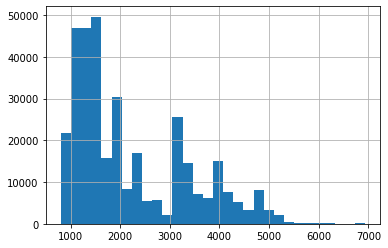

In [10]:
races["DistanceInMeters"].hist(bins=30)

#### Calculate Horse Stats

Calculate the speed of each horse in the race

<AxesSubplot:xlabel='DistanceInMeters', ylabel='Speed'>

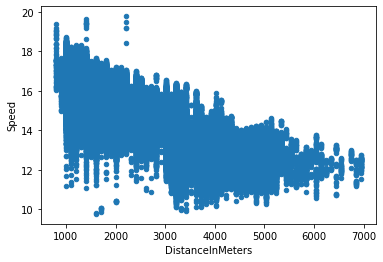

In [11]:
races["Speed"] = races["DistanceInMeters"] / races["RaceTimeInSeconds"]

# Deal with invalid data (usually invalid race time) - fastest horse (over short distance) 55mps or approx 25 m/s
races.loc[races["Speed"] > 25, "Speed"] = np.nan

races.plot.scatter(x="DistanceInMeters", y="Speed")

In [12]:
# Deal with invalid data - occasionally weight will be undefined (usually zero)
races.loc[races["WeightInPounds"] < 10, "WeightInPounds"] = np.nan

Calculate the number of horse in each race

In [13]:
groups = races.groupby(['RaceId']).apply(lambda g: pd.Series({'HorseCount': g['RaceId'].count()}, index=['HorseCount']))
races = pd.merge(races, groups, how='left', on=['RaceId'])

Define feature factory abstraction that calculates feature values based on previous history (either in total or over a time window)

In [14]:
from ipywidgets import IntProgress
from IPython.display import display

class RaceDataProcessor(ABC):

    def before_process_data(self, df: pd.DataFrame) -> None:
        # Update the underlying DataFrame before processing to e.g. set default values for new features
        pass

    def update(self, df : pd.DataFrame, history : pd.DataFrame, daily_slice : pd.DataFrame) -> None:
        # Update the processor with data
        pass


    def process_race_data(self, df : pd.DataFrame) -> None:
        df_start = df['Off'].min().date()
        slice_start = df_start + timedelta(days=1)
        df_end = df['Off'].max().date() + timedelta(days=1)
        
        days = (df_end - slice_start).days
        f = IntProgress(min=0, max=days) # instantiate the bar
        display(f)

        self.before_process_data(df)
        while slice_start < df_end:
            slice_end = slice_start + timedelta(days=1)
            history = df[df['Off'].dt.date < slice_start]
            daily_slice = df[(df['Off'].dt.date >= slice_start) & (df['Off'].dt.date < slice_end)]
            self.update(df, history, daily_slice)
            slice_start = slice_end
            f.value += 1


Calculate, for each race, whether the horse and jockey are known (i.e. have previously been involved in a race)

In [15]:
class CalculateRacesWithKnownHorsesAndJockeys(RaceDataProcessor):
    def before_process_data(self, df: pd.DataFrame) -> None:
        df["KnownHorseAndJockey"] = False

    def update(self, df : pd.DataFrame, history : pd.DataFrame, daily_slice : pd.DataFrame) -> None:
        known_jockeys = history['JockeyId'].unique().tolist()
        known_runners = history['HorseId'].unique().tolist()
        temp = daily_slice.groupby('RaceId').apply(lambda g: self.__calculate_counts_for_race_group(g, known_jockeys, known_runners))
        temp = temp[(temp['HorseCount'] == temp['KnownJockeyCount']) & (temp['HorseCount'] == temp['KnownHorseCount'])]
        races_with_known_horses_and_jockeys = temp.reset_index()['RaceId'].unique().tolist()
        df.loc[df['RaceId'].isin(races_with_known_horses_and_jockeys), "KnownHorseAndJockey"] = True

    def __calculate_counts_for_race_group(self, race_group, known_jockeys, known_runners) -> pd.Series:
        new_columns = {'HorseCount': race_group['HorseId'].count()}
        new_columns['KnownHorseCount'] = race_group[race_group['HorseId'].isin(known_runners)]['HorseId'].count()
        new_columns['KnownJockeyCount'] = race_group[race_group['JockeyId'].isin(known_jockeys)]['JockeyId'].count()
        return pd.Series(new_columns, index=['HorseCount', 'KnownHorseCount', 'KnownJockeyCount']) 


In [16]:
CalculateRacesWithKnownHorsesAndJockeys().process_race_data(races)

IntProgress(value=0, max=790)

Calculate stats for each horse in the given daily slice based on the history up until that point

In [17]:
class CalculateHorsesStats(RaceDataProcessor):
    NUMBER_OF_PRIOR_RACES = "NumberOfPriorRaces"
    LAST_RACE_GOING = "LastRaceGoing"
    LAST_RACE_SURFACE = "LastRaceSurface"
    LAST_RACE_DISTANCE = "LastRaceDistanceInMeters"
    LAST_RACE_WEIGHT = "LastRaceWeightInPounds"
    LAST_RACE_SPEED = "LastRaceSpeed"
    DAYS_REST_SINCE_LAST_RACE = "DaysRested"
    LAST_RACE_ODDS = "LastRaceDecimalOdds"
    LAST_RACE_OFFICIAL_RATING = "LastRaceOfficialRating"
    LAST_RACE_RACING_POST_RATING = "LastRaceRacingPostRating"
    LAST_RACE_TOP_SPEED_RATING = "LastRaceTopSpeedRating"
    AVG_RELATIVE_FINISHING_POSITION = "LastRaceAvgRelFinishingPosition"
    ONE_DAY = np.timedelta64(1, 'D')

    def before_process_data(self, df: pd.DataFrame) -> None:
        df.loc[:, self.NUMBER_OF_PRIOR_RACES] = 1
        df.loc[:, self.LAST_RACE_GOING] = np.nan
        self.new_column_names = ([
            self.NUMBER_OF_PRIOR_RACES,
            self.LAST_RACE_GOING,
            self.LAST_RACE_SURFACE,
            self.LAST_RACE_DISTANCE,
            self.LAST_RACE_WEIGHT,
            self.LAST_RACE_SPEED,
            self.DAYS_REST_SINCE_LAST_RACE,
            self.LAST_RACE_ODDS,
            self.LAST_RACE_OFFICIAL_RATING,
            self.LAST_RACE_RACING_POST_RATING,
            self.LAST_RACE_TOP_SPEED_RATING,
            self.AVG_RELATIVE_FINISHING_POSITION] + 
            [f"LastRace{surface}" for surface in surface_categories] +
            [f"LastRace{going}" for going in going_categories] +
            [f"LastRace{race_type_category}" for race_type_category in race_type_categories])

    def update(self, df : pd.DataFrame, history : pd.DataFrame, daily_slice : pd.DataFrame) -> None:
        slice_date = np.datetime64(daily_slice["Off"].min().date())
        slice_horses = daily_slice["HorseId"].unique().tolist()
        horse_history = history[history["HorseId"].isin(slice_horses)].sort_values(["HorseId", "Off"], ascending=[True, False])
        if len(horse_history) > 0:
            stats = horse_history.groupby("HorseId").apply(lambda g: self.__calculate_counts_for_race_group(slice_date, g))
            daily_stats = pd.merge(daily_slice.drop(self.new_column_names, axis=1, errors='ignore'), stats, how="left", on=["HorseId"])
            df.loc[df.index.isin(daily_slice.index), self.new_column_names] = daily_stats[self.new_column_names].values

    def __calculate_counts_for_race_group(self, current_date: np.datetime64, horse_races: pd.DataFrame) -> pd.Series:
        new_columns = {self.NUMBER_OF_PRIOR_RACES: horse_races["RaceId"].count()}
        last_race = horse_races.head(1) # Data already ordered in Off descending order
        new_columns[self.LAST_RACE_GOING] = last_race["Going"].values[0]
        new_columns[self.LAST_RACE_SURFACE] = last_race["Surface"].values[0]
        new_columns[self.LAST_RACE_DISTANCE] = last_race["DistanceInMeters"].values[0]
        new_columns[self.LAST_RACE_WEIGHT] = last_race["WeightInPounds"].values[0]
        new_columns[self.LAST_RACE_SPEED] = last_race["Speed"].values[0]
        new_columns[self.DAYS_REST_SINCE_LAST_RACE] = math.ceil((current_date - last_race["Off"].values[0]) / self.ONE_DAY)
        new_columns[self.LAST_RACE_ODDS] = last_race["DecimalOdds"].values[0]
        new_columns[self.LAST_RACE_OFFICIAL_RATING] = last_race["OfficialRating"].values[0]
        new_columns[self.LAST_RACE_RACING_POST_RATING] = last_race["RacingPostRating"].values[0]
        new_columns[self.LAST_RACE_TOP_SPEED_RATING] = last_race["TopSpeedRating"].values[0]
        new_columns[self.AVG_RELATIVE_FINISHING_POSITION] = (horse_races["FinishingPosition"] / horse_races["HorseCount"]).mean()
        for going in going_categories:
            new_columns[f"LastRace{going}"] = last_race[going].values[0]
        for surface in surface_categories:
            new_columns[f"LastRace{surface}"] = last_race[surface].values[0]
        for race_type_category in race_type_categories:
            new_columns[f"LastRace{race_type_category}"] = last_race[race_type_category].values[0]
        return pd.Series(new_columns, index=self.new_column_names) 


In [18]:
CalculateHorsesStats().process_race_data(races)

IntProgress(value=0, max=790)

### Evaluating previous horse performance

Now that we have calculated stats for each horse based on the previous races, we can try to figure out if any of the attributes we have relating to previous performance correlate to a horses likelihood of beating another horse in the next race. 

Possible performance attributes are:

- Racing post rating
- Official rating
- Top speed rating
- Odds 
- Average relative position (i.e. position divided by number of runners in race)



In [19]:
def calculate_correlation_of_race_attribute(attribute: str) -> np.float64:
    head = races[["RaceId", "HorseId", "FinishingPosition", attribute]]
    cross = pd.merge(head, head, on='RaceId')
    head2head = cross[cross["HorseId_x"] > cross["HorseId_y"]].copy().dropna()
    head2head["XBeatsY"] = head2head["FinishingPosition_x"] < head2head["FinishingPosition_y"]
    head2head["Relative"] = head2head[f"{attribute}_x"] - head2head[f"{attribute}_y"]
    return head2head[["XBeatsY", "Relative"]].corr(method="spearman")["XBeatsY"]["Relative"]

In [20]:
rp_corr = calculate_correlation_of_race_attribute("LastRaceRacingPostRating")
or_corr = calculate_correlation_of_race_attribute("LastRaceOfficialRating")
ts_corr = calculate_correlation_of_race_attribute("LastRaceTopSpeedRating")
odds_corr = calculate_correlation_of_race_attribute("LastRaceDecimalOdds")
lr_corr = calculate_correlation_of_race_attribute("LastRaceAvgRelFinishingPosition")
print(f"Correlation for Racing Post Rating {rp_corr}, Official Rating {or_corr}, Top Speed Rating {ts_corr}, Odds {odds_corr}, Avg finish {lr_corr}")

Correlation for Racing Post Rating 0.24514384282948842, Official Rating 0.033637127223897036, Top Speed Rating 0.17203954996487103, Odds -0.21822518707552852, Avg finish -0.24744708890866773


#### Conclusions

Racing post rating most strongly correlates with next race performance, other rating attributes not so much.
Official rating correlation is particularly poor. The problem with all these rating is that there are many rows where the values are undefined.

As expected odds and average finishing position are OK negative correlation indicators of prior performance (i.e. lower values correlate to finishing better). The benefits of these indicators is that they are always available for all horses.

However, all these attributes are actually relatively weak on their own (finishing position being the best with a correlation of -0.249). The predictive power is likely to be in combination with other factors. 

#### Calculate Jockey Stats

In [21]:
class CalculateJockeyStats(RaceDataProcessor):
    NUMBER_OF_PRIOR_RACES = "JockeyNumberOfPriorRaces"
    DAYS_SINCE_LAST_RACE = "DaysSinceJockeyLastRaced"
    WIN_PERCENTAGE = "JockeyWinPercentage"
    TOP_THREE_FINISH_PERCENTAGE = "JockeyTop3Percentage"
    AVG_RELATIVE_FINISHING_POSITION = "JockeyAvgRelFinishingPosition"
    ONE_DAY = np.timedelta64(1, 'D')


    def before_process_data(self, df: pd.DataFrame) -> None:
        df.loc[:, self.NUMBER_OF_PRIOR_RACES] = 1
        self.new_column_names = [
            self.NUMBER_OF_PRIOR_RACES,
            self.DAYS_SINCE_LAST_RACE,
            self.WIN_PERCENTAGE,
            self.TOP_THREE_FINISH_PERCENTAGE,
            self.AVG_RELATIVE_FINISHING_POSITION]

    def update(self, df : pd.DataFrame, history : pd.DataFrame, daily_slice : pd.DataFrame) -> None:
        slice_jockeys = daily_slice["JockeyId"].unique().tolist()
        jockey_history = history[history["JockeyId"].isin(slice_jockeys)].sort_values(["JockeyId", "Off"], ascending=[True, False])
        if len(jockey_history) > 0:
            slice_date = np.datetime64(daily_slice["Off"].min().date())
            stats = jockey_history.groupby("JockeyId").apply(lambda g: self.__calculate_counts_for_race_group(slice_date, g))
            daily_stats = pd.merge(daily_slice.drop(self.new_column_names, axis=1, errors='ignore'), stats, how="left", on=["JockeyId"])
            df.loc[df.index.isin(daily_slice.index), self.new_column_names] = daily_stats[self.new_column_names].values

    def __calculate_counts_for_race_group(self, current_date: np.datetime64, jockey_races: pd.DataFrame) -> pd.Series:
        number_of_races = jockey_races["RaceId"].count()
        new_columns = {self.NUMBER_OF_PRIOR_RACES: number_of_races}
        last_race = jockey_races.head(1) # Data already ordered in Off descending order
        new_columns[self.DAYS_SINCE_LAST_RACE] = math.ceil((current_date - last_race["Off"].values[0]) / self.ONE_DAY)
        wins = len(jockey_races[jockey_races["FinishingPosition"] == 1])
        new_columns[self.WIN_PERCENTAGE] = wins / number_of_races
        top_finishes = len(jockey_races[jockey_races["FinishingPosition"] < 4])
        new_columns[self.TOP_THREE_FINISH_PERCENTAGE] = top_finishes / number_of_races        
        average_position = (jockey_races["FinishingPosition"] / jockey_races["HorseCount"]).mean()
        new_columns[self.AVG_RELATIVE_FINISHING_POSITION] = average_position
        return pd.Series(new_columns, index=self.new_column_names) 


In [22]:
CalculateJockeyStats().process_race_data(races)

IntProgress(value=0, max=790)

In [23]:
wp_corr = calculate_correlation_of_race_attribute("JockeyWinPercentage")
pp_corr = calculate_correlation_of_race_attribute("JockeyTop3Percentage")
fp_corr = calculate_correlation_of_race_attribute("JockeyAvgRelFinishingPosition")
print(f"Correlation for Win percentage {wp_corr}, place percentage {pp_corr}, average finishing position {fp_corr}")

Correlation for Win percentage 0.13967881131964596, place percentage 0.15175341063145034, average finishing position -0.15600064857889281


#### Conclusions

Win and place percentage are OK positive correlation indicator of prior performance. Average finishing position is an OK negative correlation indicator of prior performance (i.e. lower values correlate to finishing better).

However, all these attributes are actually relatively weak on there own (finishing position being the best with a correlation of -0.136). The predictive power is likely to be in combination with other factors. 

### Examples

In [24]:
oriental_lilly_races = races[races["HorseId"] == 1439510]
oriental_lilly_races[["Off", "HorseId", "HorseName", "NumberOfPriorRaces", "FinishingPosition", "DaysRested", "LastRaceAvgRelFinishingPosition"] + [f"LastRace{going}" for going in going_categories]]

,Off,HorseId,HorseName,NumberOfPriorRaces,FinishingPosition,DaysRested,LastRaceAvgRelFinishingPosition,LastRaceGoing_Good,LastRaceGoing_Good_To_Soft,LastRaceGoing_Soft,LastRaceGoing_Good_To_Firm,LastRaceGoing_Firm,LastRaceGoing_Heavy
8730,2021-08-09 16:05:00,1439510,Oriental Lilly,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13888,2021-08-20 20:37:00,1439510,Oriental Lilly,1.0,5,11.0,0.916667,0.0,0.0,1.0,0.0,0.0,0.0
20291,2021-09-03 15:50:00,1439510,Oriental Lilly,2.0,3,14.0,0.636905,0.0,1.0,0.0,0.0,0.0,0.0
25961,2021-09-16 15:35:00,1439510,Oriental Lilly,3.0,10,13.0,0.515512,1.0,0.0,0.0,0.0,0.0,0.0
32173,2021-09-27 20:30:00,1439510,Oriental Lilly,4.0,2,11.0,0.636634,0.0,0.0,0.0,1.0,0.0,0.0
54701,2021-11-08 19:30:00,1439510,Oriental Lilly,5.0,1,42.0,0.537879,0.0,1.0,0.0,0.0,0.0,0.0
63090,2021-11-30 17:45:00,1439510,Oriental Lilly,6.0,2,22.0,0.460137,0.0,1.0,0.0,0.0,0.0,0.0
68937,2021-12-14 19:00:00,1439510,Oriental Lilly,7.0,3,14.0,0.416381,1.0,0.0,0.0,0.0,0.0,0.0
75547,2022-01-01 16:30:00,1439510,Oriental Lilly,8.0,10,18.0,0.401834,1.0,0.0,0.0,0.0,0.0,0.0
79445,2022-01-13 14:20:00,1439510,Oriental Lilly,9.0,4,12.0,0.436550,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
# 6901 84857
james_races = races[(races["JockeyId"] == 6901)].dropna()
james_races[["Off", "JockeyId", "JockeyName", "JockeyNumberOfPriorRaces", "FinishingPosition", "HorseCount", "JockeyAvgRelFinishingPosition", "JockeyWinPercentage", "JockeyTop3Percentage"]]

,Off,JockeyId,JockeyName,JockeyNumberOfPriorRaces,FinishingPosition,HorseCount,JockeyAvgRelFinishingPosition,JockeyWinPercentage,JockeyTop3Percentage
7624,2021-08-07 14:35:00,6901,James Doyle,58.0,5,10,0.483584,0.224138,0.517241
9972,2021-08-12 14:55:00,6901,James Doyle,74.0,7,7,0.481642,0.216216,0.527027
12078,2021-08-16 14:40:00,6901,James Doyle,88.0,2,8,0.497661,0.181818,0.454545
12929,2021-08-18 15:00:00,6901,James Doyle,95.0,1,8,0.498634,0.178947,0.463158
12950,2021-08-18 16:10:00,6901,James Doyle,95.0,7,14,0.498634,0.178947,0.463158
...,...,...,...,...,...,...,...,...,...
344240,2023-09-08 15:45:00,6901,James Doyle,1239.0,5,10,0.464739,0.191283,0.493947
344733,2023-09-09 15:35:00,6901,James Doyle,1245.0,16,16,0.465188,0.191968,0.493173
344734,2023-09-09 16:10:00,6901,James Doyle,1245.0,1,12,0.465188,0.191968,0.493173
347821,2023-09-15 17:30:00,6901,James Doyle,1259.0,4,10,0.466099,0.193805,0.493249


### Output

In [26]:
races.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349521 entries, 0 to 349520
Data columns (total 70 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   RaceId                           349521 non-null  int64         
 1   CourseId                         349521 non-null  int64         
 2   RaceType                         349521 non-null  object        
 3   Off                              349521 non-null  datetime64[ns]
 4   DecimalOdds                      347296 non-null  float64       
 5   OfficialRating                   212151 non-null  float64       
 6   RacingPostRating                 310752 non-null  float64       
 7   TopSpeedRating                   248057 non-null  float64       
 8   DistanceInMeters                 349521 non-null  int64         
 9   Going                            349521 non-null  object        
 10  Surface                          349521 non-

In [27]:
races.to_csv("Race_Features.csv", index=False)